# Experiments with DeepSEA and DanQ

Train the DeepSEA models with different sequence feature orders and using different sequence context lengths.
In order to train the models from scratch, remove the '-evaluate' option.
Training these models takes a significant amout of time, so if possible, we suggest to run these scripts in parallel (outside of the notebook).

In [1]:
import os
%load_ext rpy2.ipython

from IPython.display import Image

In [ ]:
!python run_genomics_model.py -o 1 -flank 150 -model dsea -evaluate
!python run_genomics_model.py -o 2 -flank 150 -model dsea -evaluate
!python run_genomics_model.py -o 3 -flank 150 -model dsea -evaluate

!python run_genomics_model.py -o 1 -model dsea -evaluate
!python run_genomics_model.py -o 2 -model dsea -evaluate
!python run_genomics_model.py -o 3 -model dsea -evaluate

!python run_genomics_model.py -o 1 -flank 900 -model dsea -evaluate
!python run_genomics_model.py -o 2 -flank 900 -model dsea -evaluate
!python run_genomics_model.py -o 3 -flank 900 -model dsea -evaluate


Similarly, DanQ is evaluated (or trained by removing the -evaluate option) using

In [ ]:
!python run_genomics_model.py -o 1 -flank 150 -model danq -evaluate
!python run_genomics_model.py -o 2 -flank 150 -model danq -evaluate
!python run_genomics_model.py -o 3 -flank 150 -model danq -evaluate

!python run_genomics_model.py -o 1 -model danq -evaluate
!python run_genomics_model.py -o 2 -model danq -evaluate
!python run_genomics_model.py -o 3 -model danq -evaluate

!python run_genomics_model.py -o 1 -flank 900 -model danq -evaluate
!python run_genomics_model.py -o 2 -flank 900 -model danq -evaluate
!python run_genomics_model.py -o 3 -flank 900 -model danq -evaluate

## Evaluate performance difference due to strandedness for different sequence feature orders

In [2]:
%%R
library(ggplot2)

# load data
r11 = data.frame(auprc=t(as.matrix(read.table('deepsea_results/evaluation/dsea_ssingle_o1_f400_aTrue_rr1/auprc.tsv',header=T))))
r12 = data.frame(auprc=t(as.matrix(read.table('deepsea_results/evaluation/dsea_sdouble_o1_f400_aTrue_rr1/auprc.tsv',header=T))))


r21 = data.frame(auprc=t(as.matrix(read.table('deepsea_results/evaluation/dsea_ssingle_o2_f400_aTrue_rr1/auprc.tsv',header=T))))
r22 = data.frame(auprc=t(as.matrix(read.table('deepsea_results/evaluation/dsea_sdouble_o2_f400_aTrue_rr1/auprc.tsv',header=T))))

r31 = data.frame(auprc=t(as.matrix(read.table('deepsea_results/evaluation/dsea_ssingle_o3_f400_aTrue_rr1/auprc.tsv',header=T))))
r32 = data.frame(auprc=t(as.matrix(read.table('deepsea_results/evaluation/dsea_sdouble_o3_f400_aTrue_rr1/auprc.tsv',header=T))))

# extract labels and categories
labels=data.frame(ids=rownames(r22))
labels$type = ""
labels$type[startsWith(as.character(labels$ids), 'E')] = "Histone"
labels$type[startsWith(as.character(labels$ids), 'wgEncodeAwgTfbs')] = "Tfbs"
labels$type[startsWith(as.character(labels$ids), 'wgEncodeAwgDnase')] = "Dnase"

df = data.frame(auprc1=r11$auprc, auprc2=r12$auprc, type=labels$type, labels=labels$ids)
print(sprintf("Order 1: diff-auPRC=%f", mean(df$auprc2-df$auprc1)))
df = data.frame(auprc1=r21$auprc, auprc2=r22$auprc, type=labels$type, labels=labels$ids)
mean(df$auprc2-df$auprc1)
print(sprintf("Order 2: diff-auPRC=%f", mean(df$auprc2-df$auprc1)))
df = data.frame(auprc1=r31$auprc, auprc2=r32$auprc, type=labels$type, labels=labels$ids)
mean(df$auprc2-df$auprc1)
print(sprintf("Order 3: diff-auPRC=%f", mean(df$auprc2-df$auprc1)))


[1] "Order 1: diff-auPRC=0.001042"
[1] "Order 2: diff-auPRC=0.006038"
[1] "Order 3: diff-auPRC=0.013773"


## Compare DeepSEA and DanQ performances

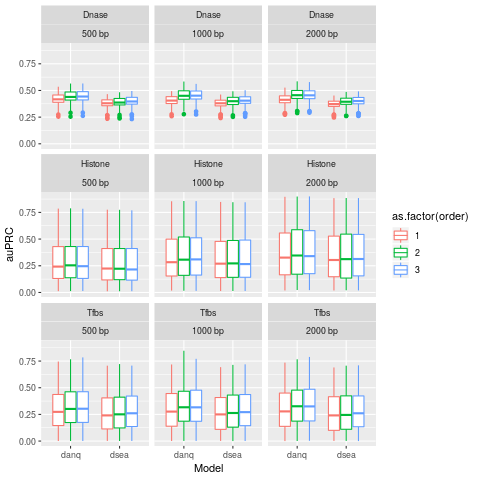

In [7]:
%%R

library(ggplot2)
library(ggrepel)
library(dplyr)
models = c("dsea", "danq")
orders = c(1,2,3)
flanks = c(150, 400, 900)

# we need to extract the label names
r211 <- data.frame(auprc=t(as.matrix(read.table('deepsea_results/evaluation/danq_sdouble_o1_f150_aTrue_rr1/auprc.tsv',header=T))))
labels <- data.frame(ids=rownames(r211))

# we need to obtain all results
list_frames <- list()
for (model in models) {
  for (order in orders) {
    for (flank in flanks) {
      list_frames[[length(list_frames)+1]] <- data.frame(auprc=t(as.matrix(read.table(sprintf('deepsea_results/evaluation/%s_sdouble_o%d_f%d_aTrue_rr1/auprc.tsv', model, order, flank),header=T))),
                                                       ids=labels,
                                                       model=model,
                                                       order=order,
                                                       wsize=2*flank + 200)
    }
  }
}


df<-bind_rows(list_frames)
df$type = ""
df$type[startsWith(as.character(df$ids), 'E')] = "Histone"
df$type[startsWith(as.character(df$ids), 'wgEncodeAwgTfbs')] = "Tfbs"
df$type[startsWith(as.character(df$ids), 'wgEncodeAwgDnase')] = "Dnase"

x=c("500"="500 bp", "1000"="1000 bp", "2000"="2000 bp")
g4 <- ggplot(df, aes(x=model, y=auprc, color=as.factor(order))) +
  geom_boxplot() +
  facet_wrap(.~type + wsize, ncol=3,
             labeller=labeller(wsize=x)) + ylab("auPRC") + xlab("Model")

print(g4)
#ggsave("figure/compare_danq_vs_dsea.png", g4)


## Investigate the influence of sequence context lengths

Next, we illstrate how the context window lengths affects the performances for the DeepSEA model

In [26]:
%%R

library(ggplot2)
library(ggrepel)


# load data
r11 = data.frame(auprc=t(as.matrix(read.table('deepsea_results/evaluation/dsea_sdouble_o1_f150_aTrue_rr1/auprc.tsv',header=T))))
r12 = data.frame(auprc=t(as.matrix(read.table('deepsea_results/evaluation/dsea_sdouble_o1_f400_aTrue_rr1/auprc.tsv',header=T))))
r13 = data.frame(auprc=t(as.matrix(read.table('deepsea_results/evaluation/dsea_sdouble_o1_f900_aTrue_rr1/auprc.tsv',header=T))))

# extract labels and categories
labels=data.frame(ids=rownames(r22))
labels$type = ""
labels$type[startsWith(as.character(labels$ids), 'E')] = "Histone"
labels$type[startsWith(as.character(labels$ids), 'wgEncodeAwgTfbs')] = "Tfbs"
labels$type[startsWith(as.character(labels$ids), 'wgEncodeAwgDnase')] = "Dnase"


df = data.frame(auprc1=r11$auprc, auprc2=r12$auprc, auprc3=r13$auprc, 
                type=labels$type, 
                labels=as.character(labels$ids), 
                stringsAsFactors = FALSE)

source("make_labels.R")


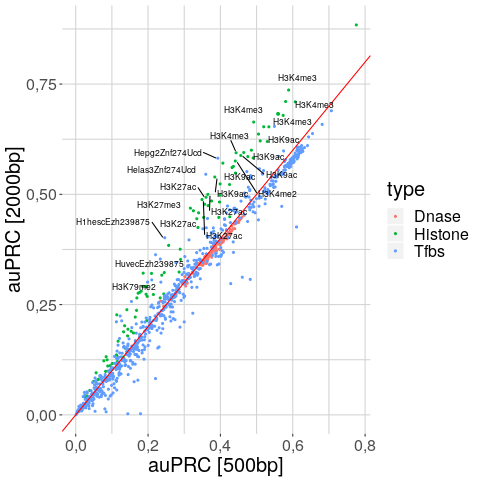

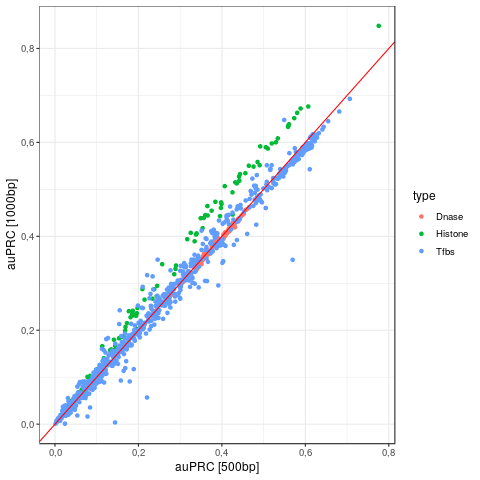

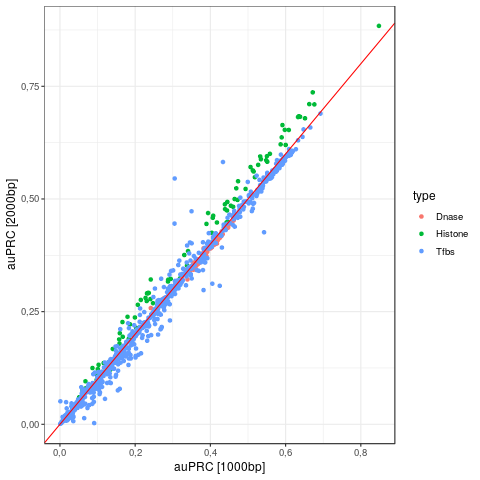

In [29]:
%%R

g1 = ggplot(df, aes(x=auprc1, y=auprc3, color=type)) + geom_point(size=.8) +
  xlab("auPRC [500bp]") + ylab("auPRC [2000bp]") +  geom_abline(intercept=0.0, slope=1., color="red") +
  theme(
        text=element_text(size=20),
        panel.background= element_blank(),
        panel.grid.major.y=element_line(size = 0.5, linetype = 'solid',
                                        colour = "lightgray"),
        panel.grid.minor.y=element_line(size = 0.5, linetype = 'solid',
                                        colour = "lightgray"),
        panel.grid.major.x=element_line(size = 0.5, linetype = 'solid',
                                        colour = "lightgray"),
        panel.grid.minor.x=element_line(size = 0.5, linetype = 'solid',
                                        colour = "lightgray")) +
  geom_text_repel(
    data = subset(df, auprc3-auprc1 >=.13),
    aes(label = labels),
    size = 3,
    box.padding = unit(0.35, "lines"),
    point.padding = unit(0.3, "lines"),
    color='black',
  )
#    theme_bw(base_size = 12)
print(g1)

g2 = ggplot(df, aes(x=auprc1, y=auprc2, color=type)) + geom_point() +
  xlab("auPRC [500bp]") + ylab("auPRC [1000bp]")  +
  geom_abline(intercept=0.0, slope=1., color="red") +
  theme_bw(base_size = 12)
print(g2)
g3 = ggplot(df, aes(x=auprc2, y=auprc3, color=type)) + geom_point() +
  xlab("auPRC [1000bp]") + ylab("auPRC [2000bp]")  +
  geom_abline(intercept=0.0, slope=1., color="red") +
  theme_bw(base_size = 12)
print(g3)

# ggsave("figure/compare_500_vs_2000_typelabel.png", g1)


For histone modifications as well as for histone modifiers, 
we observe an improved performance due the the elongated context window.
This is not observed for DNAse and TFBS, generally.


Similarly, we infestigate this effect for DanQ

In [30]:
%%R

# load data
r11 = data.frame(auprc=t(as.matrix(read.table('deepsea_results/evaluation/danq_sdouble_o3_f150_aTrue_rr1/auprc.tsv',header=T))))
r12 = data.frame(auprc=t(as.matrix(read.table('deepsea_results/evaluation/danq_sdouble_o3_f400_aTrue_rr1/auprc.tsv',header=T))))
r13 = data.frame(auprc=t(as.matrix(read.table('deepsea_results/evaluation/danq_sdouble_o3_f900_aTrue_rr1/auprc.tsv',header=T))))


# extract labels and categories
labels=data.frame(ids=rownames(r12))
labels$type = ""
labels$type[startsWith(as.character(labels$ids), 'E')] = "Histone"
labels$type[startsWith(as.character(labels$ids), 'wgEncodeAwgTfbs')] = "Tfbs"
labels$type[startsWith(as.character(labels$ids), 'wgEncodeAwgDnase')] = "Dnase"


df = data.frame(auprc1=r11$auprc, auprc2=r12$auprc, auprc3=r13$auprc, type=labels$type, labels=as.character(labels$ids), stringsAsFactors = FALSE)

source("make_labels.R")



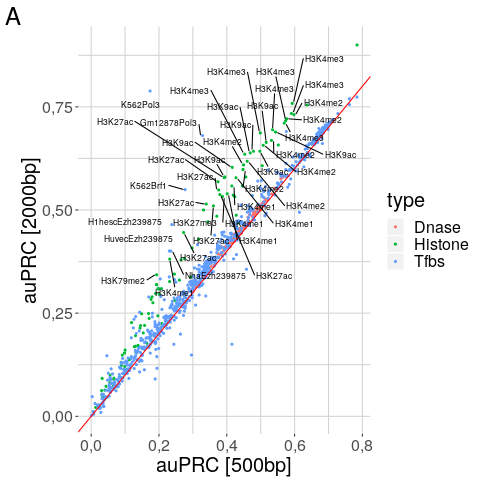

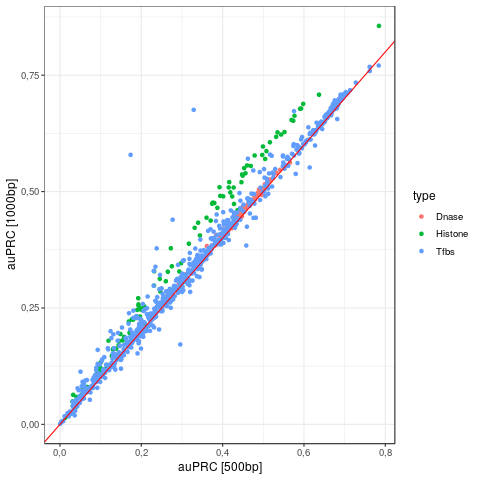

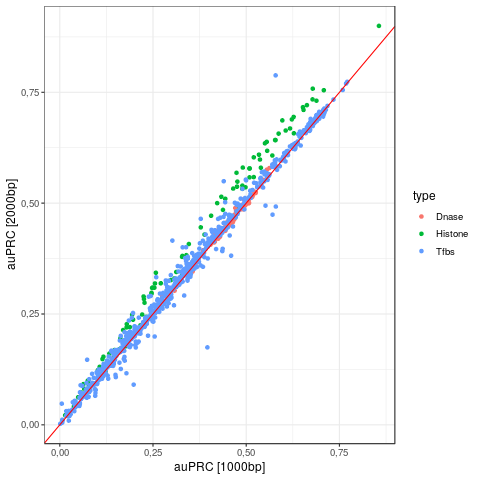

In [33]:
%%R

g1 = ggplot(df, aes(x=auprc1, y=auprc3, color=type)) + geom_point(size=.8) +
  xlab("auPRC [500bp]") + ylab("auPRC [2000bp]") +  geom_abline(intercept=0.0, slope=1., color="red") + labs(tag="A") +
  theme(
        text=element_text(size=20),
        panel.background= element_blank(),
        panel.grid.major.y=element_line(size = 0.5, linetype = 'solid',
                                        colour = "lightgray"),
        panel.grid.minor.y=element_line(size = 0.5, linetype = 'solid',
                                        colour = "lightgray"),
        panel.grid.major.x=element_line(size = 0.5, linetype = 'solid',
                                        colour = "lightgray"),
        panel.grid.minor.x=element_line(size = 0.5, linetype = 'solid',
                                        colour = "lightgray")) +
  geom_text_repel(
    data = subset(df, auprc3-auprc1 >=.13),
    aes(label = labels),
    size = 3,
    box.padding = unit(0.35, "lines"),
    point.padding = unit(0.3, "lines"),
    color='black',
  )
#    theme_bw(base_size = 12)
print(g1)

#ggsave("figure/compare_500_vs_2000_typelabel_danq.png", g1, width=7, height=3)

g2 = ggplot(df, aes(x=auprc1, y=auprc2, color=type)) + geom_point() +
  xlab("auPRC [500bp]") + ylab("auPRC [1000bp]")  +
  geom_abline(intercept=0.0, slope=1., color="red") +
  theme_bw(base_size = 12)
print(g2)
g3 = ggplot(df, aes(x=auprc2, y=auprc3, color=type)) + geom_point() +
  xlab("auPRC [1000bp]") + ylab("auPRC [2000bp]")  +
  geom_abline(intercept=0.0, slope=1., color="red") +
  theme_bw(base_size = 12)
print(g3)


## Investigate the sequence feature order influence

First, the results from DeepSEA suggest that for a number of TFs, a significant performance improvement is obtained 
from using higher-order features.

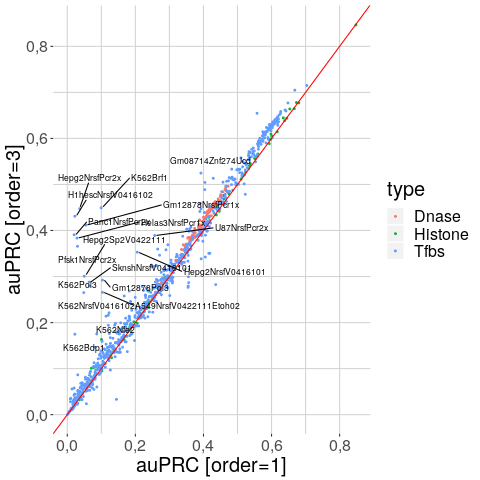

In [35]:
%%R

# load data

r12 = data.frame(auprc=t(as.matrix(read.table('deepsea_results/evaluation/dsea_sdouble_o1_f400_aTrue_rr2/auprc.tsv',header=T))))
r22 = data.frame(auprc=t(as.matrix(read.table('deepsea_results/evaluation/dsea_sdouble_o2_f400_aTrue_rr2/auprc.tsv',header=T))))
r32 = data.frame(auprc=t(as.matrix(read.table('deepsea_results/evaluation/dsea_sdouble_o3_f400_aTrue_rr2/auprc.tsv',header=T))))


# extract labels and categories
labels=data.frame(ids=rownames(r22))
labels$type = ""
labels$type[startsWith(as.character(labels$ids), 'E')] = "Histone"
labels$type[startsWith(as.character(labels$ids), 'wgEncodeAwgTfbs')] = "Tfbs"
labels$type[startsWith(as.character(labels$ids), 'wgEncodeAwgDnase')] = "Dnase"

df = data.frame(auprc1=r12$auprc, auprc2=r22$auprc, auprc3=r32$auprc, type=labels$type,
                labels=as.character(labels$ids), stringsAsFactors = FALSE)

source("make_labels.R")


g1 = ggplot(df, aes(x=auprc1, y=auprc3, color=type)) + geom_point(size=.7) +
  xlab("auPRC [order=1]") + ylab("auPRC [order=3]") +  geom_abline(intercept=0.0, slope=1., color="red") +
  theme(text=element_text(size=20),
        panel.background= element_blank(),
        panel.grid.major.y=element_line(size = 0.5, linetype = 'solid',
                                       colour = "lightgray"),
        panel.grid.minor.y=element_line(size = 0.5, linetype = 'solid',
                                       colour = "lightgray"),
        panel.grid.major.x=element_line(size = 0.5, linetype = 'solid',
                                   colour = "lightgray"),
        panel.grid.minor.x=element_line(size = 0.5, linetype = 'solid',
                                        colour = "lightgray")) +
  geom_text_repel(
    data = subset(df, auprc3-auprc1 >=.1),
    aes(label = labels),
    size = 3,
    box.padding = unit(0.35, "lines"),
    point.padding = unit(0.3, "lines"),
    color='black',
  )

print(g1)


[1] 39


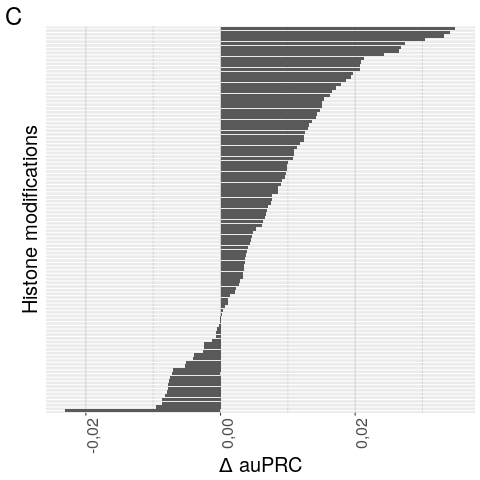

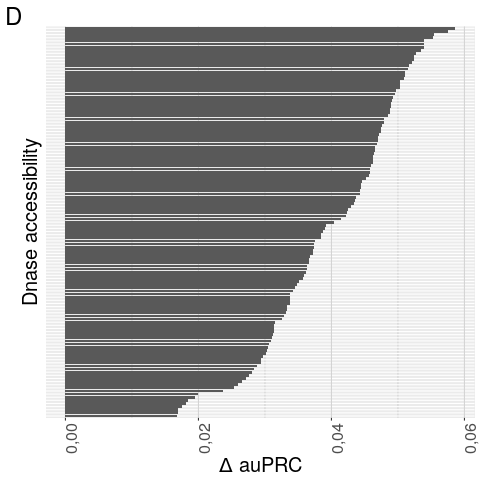

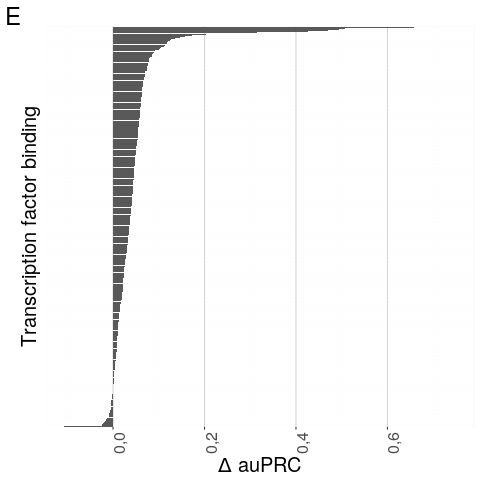

In [38]:
%%R

# load data

r11 = data.frame(auprc=t(as.matrix(read.table('deepsea_results/evaluation/danq_sdouble_o1_f900_aTrue_rr1/auprc.tsv',header=T))))
r21 = data.frame(auprc=t(as.matrix(read.table('deepsea_results/evaluation/danq_sdouble_o2_f900_aTrue_rr1/auprc.tsv',header=T))))
r31 = data.frame(auprc=t(as.matrix(read.table('deepsea_results/evaluation/danq_sdouble_o3_f900_aTrue_rr1/auprc.tsv',header=T))))


# extract labels and categories
labels=data.frame(ids=rownames(r21))
labels$type = ""
labels$type[startsWith(as.character(labels$ids), 'E')] = "Histone"
labels$type[startsWith(as.character(labels$ids), 'wgEncodeAwgTfbs')] = "Tfbs"
labels$type[startsWith(as.character(labels$ids), 'wgEncodeAwgDnase')] = "Dnase"

df = data.frame(auprc1=r11$auprc, auprc2=r21$auprc, auprc3=r31$auprc, type=labels$type,
                labels=as.character(labels$ids), stringsAsFactors = FALSE)

df$delta_auprc = df$auprc3 - df$auprc1

print(nrow(subset(df, type=="Tfbs" & delta_auprc>.1)))

subdf = arrange(subset(df, type=="Histone"), delta_auprc)
g1 = ggplot(subdf, aes(x=labels, y=delta_auprc)) +  scale_x_discrete(limits=subdf$labels) + coord_flip() +
   geom_bar(stat='identity') +
  theme(text=element_text(size=20),
        # panel.background = element_blank(),
        panel.grid.major.x=element_line(size = 0.5, linetype = 'solid',
                                        colour = "lightgray"),
        panel.grid.minor.x=element_line(size = 0.5, linetype = 'solid',
                                        colour = "lightgray"),
        axis.text.x = element_text(angle=90, hjust=1),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank()) +
  ylab(expression(Delta~"auPRC")) + xlab("Histone modifications") + labs(tag="C")

subdf = arrange(subset(df, type=="Dnase"), delta_auprc)
g2 = ggplot(subdf, aes(x=labels, y=delta_auprc)) +  scale_x_discrete(limits=subdf$labels) + coord_flip() +
  geom_bar(stat='identity') +
  theme(text=element_text(size=20),
        # panel.background = element_blank(),
        panel.grid.major.x=element_line(size = 0.5, linetype = 'solid',
                                        colour = "lightgray"),
        panel.grid.minor.x=element_line(size = 0.5, linetype = 'solid',
                                        colour = "lightgray"),
        axis.text.x = element_text(angle=90, hjust=1),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank()) +
  ylab(expression(Delta~"auPRC")) + xlab("Dnase accessibility") + labs(tag="D")

subdf = arrange(subset(df, type=="Tfbs"), delta_auprc)
g3 = ggplot(subdf, aes(x=labels, y=delta_auprc)) +  scale_x_discrete(limits=subdf$labels) + coord_flip() +
  geom_bar(stat='identity') +
  theme(text=element_text(size=20),
        # panel.background = element_blank(),
        panel.grid.major.x=element_line(size = 0.5, linetype = 'solid',
                                        colour = "lightgray"),
        panel.grid.minor.x=element_line(size = 0.5, linetype = 'solid',
                                        colour = "lightgray"),
        axis.text.x = element_text(angle=90, hjust=1),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank()) +
  ylab(expression(Delta~"auPRC")) + xlab("Transcription factor binding") + labs(tag="E")

print(g1)
print(g2)
print(g3)

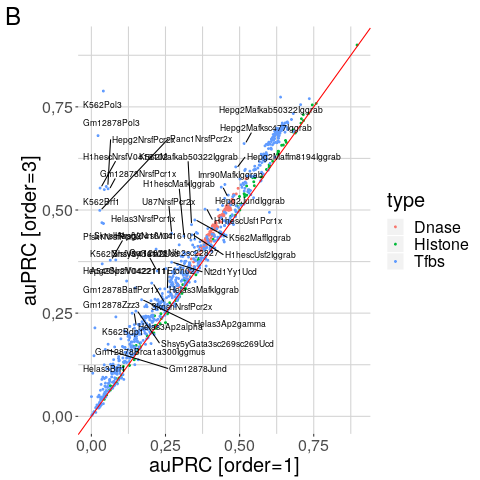

In [39]:
%%R

source("make_labels.R")

g1 = ggplot(df, aes(x=auprc1, y=auprc3, color=type)) + geom_point(size=.7) +
  xlab("auPRC [order=1]") + ylab("auPRC [order=3]") +  geom_abline(intercept=0.0, slope=1., color="red") +
  theme(text=element_text(size=20),
        panel.background= element_blank(),
        panel.grid.major.y=element_line(size = 0.5, linetype = 'solid',
                                       colour = "lightgray"),
        panel.grid.minor.y=element_line(size = 0.5, linetype = 'solid',
                                       colour = "lightgray"),
        panel.grid.major.x=element_line(size = 0.5, linetype = 'solid',
                                   colour = "lightgray"),
        panel.grid.minor.x=element_line(size = 0.5, linetype = 'solid',
                                        colour = "lightgray")) +
  geom_text_repel(
    data = subset(df, auprc3-auprc1 >=.1),
    aes(label = labels),
    size = 3,
    box.padding = unit(0.35, "lines"),
    point.padding = unit(0.3, "lines"),
    color='black',
  ) + labs(tag="B")

g1
print(g1)

# ggsave("figure/compare_1_vs_3_typelabel_danq.png", g1, width=7, height=3)
